In [1]:
import os
from pathlib import Path
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits

In [2]:
#config = {'BATCH_SIZE':128,'NUM_EPOCHS':5}
model = LeNet5(n_classes=10)
train_dataset = MNIST(
    root=Path('./tmp/'),
    download=True,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)

test_dataset = MNIST(
    root=Path('./tmp/'),
    train=False,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/train-images-idx3-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/train-labels-idx1-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to tmp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to tmp/MNIST/raw



In [3]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)

In [4]:
len(train_dataloader)

469

In [5]:
import numpy as np

def train_epoch(epoch, ds, model, criterion, optimizer, scheduler):
  model.train()
  total = 0
  correct = 0
  train_loss = 0

  for i, (inputs, targets) in enumerate(ds):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
    if scheduler is not None:
        scheduler.step()

  train_loss = train_loss / len(ds)
  accuracy = correct/total

  print(f'Epoch {epoch}: Loss: {train_loss} Batch Accuracy: {accuracy}')
  return {'train_loss': train_loss, 'train_accuracy': accuracy}

def evaluate(ds, model, criterion):
  model.eval()
  total = 0
  correct = 0
  test_loss = 0

  with torch.no_grad():
    for i, (inputs, targets) in enumerate(ds):
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

    test_loss = test_loss/len(ds)
    accuracy = correct/total

    print(f'Test Set evaluation: Loss: {test_loss} Test Accuracy: {accuracy}')
    return {'test_loss': test_loss, 'test_accuracy': accuracy}

def train(train_ds, test_ds, optimizer, model, epochs=30, scheduler=None):
  criterion = nn.CrossEntropyLoss()
  history_data = []
  for i in tqdm(range(epochs)):
    train_stats = train_epoch(i, train_ds, model, criterion, optimizer, scheduler)
    test_stats = evaluate(test_ds, model, criterion)
    history_data.append((train_stats, test_stats, optimizer.param_groups[0]['lr']))
  return history_data

In [6]:
import matplotlib.pyplot as plt
def plot_history_data(history, figname=None):
  lrs = [h[2] for h in history]
  train_loss = [h[0]['train_loss'] for h in history]
  train_accuracy = [h[0]['train_accuracy'] for h in history]

  test_loss = [h[1]['test_loss'] for h in history]
  test_accuracy = [h[1]['test_accuracy'] for h in history]
  
  fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,16))
  ax1.plot(lrs)
  ax1.set(yscale='log', xlabel='Epoch', ylabel='Learning Rate')

  ax2.plot(train_loss, label='train_loss')
  ax2.plot(test_loss, label='test_loss')
  ax2.legend()
  ax2.set(xlabel='Epoch', ylabel='Loss')

  ax3.plot(train_accuracy, label='train_accuracy')
  ax3.plot(test_accuracy, label='test_accuracy')
  ax3.legend()
  ax3.set(xlabel='Epoch', ylabel='Accuracy')

  plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0: Loss: 0.8912742818787154 Batch Accuracy: 0.7435166666666667


  3%|▎         | 1/30 [00:22<10:47, 22.32s/it]

Test Set evaluation: Loss: 0.26739180451141126 Test Accuracy: 0.9209
Epoch 1: Loss: 0.19160213373077195 Batch Accuracy: 0.9424666666666667


  7%|▋         | 2/30 [00:44<10:22, 22.21s/it]

Test Set evaluation: Loss: 0.11888590785144251 Test Accuracy: 0.9649
Epoch 2: Loss: 0.1007701868036472 Batch Accuracy: 0.9685


 10%|█         | 3/30 [01:06<10:01, 22.29s/it]

Test Set evaluation: Loss: 0.07400932292972656 Test Accuracy: 0.9762
Epoch 3: Loss: 0.07228844092567084 Batch Accuracy: 0.9777833333333333


 13%|█▎        | 4/30 [01:29<09:39, 22.27s/it]

Test Set evaluation: Loss: 0.0643696841618777 Test Accuracy: 0.9791
Epoch 4: Loss: 0.05703239353385561 Batch Accuracy: 0.98245


 17%|█▋        | 5/30 [01:51<09:17, 22.32s/it]

Test Set evaluation: Loss: 0.049749520372988396 Test Accuracy: 0.9848
Epoch 5: Loss: 0.05024621082839173 Batch Accuracy: 0.9845


 20%|██        | 6/30 [02:13<08:55, 22.32s/it]

Test Set evaluation: Loss: 0.04989746237863327 Test Accuracy: 0.9829
Epoch 6: Loss: 0.04516758246502198 Batch Accuracy: 0.9859666666666667


 23%|██▎       | 7/30 [02:36<08:32, 22.29s/it]

Test Set evaluation: Loss: 0.05029852455481887 Test Accuracy: 0.9829
Epoch 7: Loss: 0.0408032012751886 Batch Accuracy: 0.9871833333333333


 27%|██▋       | 8/30 [02:58<08:10, 22.31s/it]

Test Set evaluation: Loss: 0.042292548105550956 Test Accuracy: 0.9851
Epoch 8: Loss: 0.037409645649217275 Batch Accuracy: 0.9884166666666667


 30%|███       | 9/30 [03:20<07:48, 22.31s/it]

Test Set evaluation: Loss: 0.04355265629106449 Test Accuracy: 0.9854
Epoch 9: Loss: 0.03530408739884779 Batch Accuracy: 0.9893


 33%|███▎      | 10/30 [03:42<07:25, 22.28s/it]

Test Set evaluation: Loss: 0.041945993176018936 Test Accuracy: 0.9864
Epoch 10: Loss: 0.035347368688817056 Batch Accuracy: 0.9885666666666667


 37%|███▋      | 11/30 [04:05<07:04, 22.32s/it]

Test Set evaluation: Loss: 0.0434396009578346 Test Accuracy: 0.9867
Epoch 11: Loss: 0.030958155122921188 Batch Accuracy: 0.9909333333333333


 40%|████      | 12/30 [04:27<06:41, 22.32s/it]

Test Set evaluation: Loss: 0.03968936031613546 Test Accuracy: 0.987
Epoch 12: Loss: 0.031037450025378388 Batch Accuracy: 0.9905166666666667


 43%|████▎     | 13/30 [04:49<06:19, 22.32s/it]

Test Set evaluation: Loss: 0.03978789089795768 Test Accuracy: 0.9864
Epoch 13: Loss: 0.028795245519058824 Batch Accuracy: 0.9912333333333333


 47%|████▋     | 14/30 [05:12<05:56, 22.31s/it]

Test Set evaluation: Loss: 0.04678593987755218 Test Accuracy: 0.9852
Epoch 14: Loss: 0.027269905149094713 Batch Accuracy: 0.9917


 50%|█████     | 15/30 [05:34<05:33, 22.26s/it]

Test Set evaluation: Loss: 0.03637785912871573 Test Accuracy: 0.9873
Epoch 15: Loss: 0.027453454127207573 Batch Accuracy: 0.9920333333333333


 53%|█████▎    | 16/30 [05:56<05:11, 22.28s/it]

Test Set evaluation: Loss: 0.039717432538112274 Test Accuracy: 0.9874
Epoch 16: Loss: 0.027181839025807755 Batch Accuracy: 0.9920333333333333


 57%|█████▋    | 17/30 [06:18<04:49, 22.25s/it]

Test Set evaluation: Loss: 0.04478175659911542 Test Accuracy: 0.9853
Epoch 17: Loss: 0.02415936250738037 Batch Accuracy: 0.9926


 60%|██████    | 18/30 [06:41<04:26, 22.25s/it]

Test Set evaluation: Loss: 0.035999575332160805 Test Accuracy: 0.9881
Epoch 18: Loss: 0.024083127656371703 Batch Accuracy: 0.99305


 63%|██████▎   | 19/30 [07:03<04:04, 22.23s/it]

Test Set evaluation: Loss: 0.03212024451158292 Test Accuracy: 0.9895
Epoch 19: Loss: 0.022416554778111355 Batch Accuracy: 0.9935833333333334


 67%|██████▋   | 20/30 [07:25<03:42, 22.20s/it]

Test Set evaluation: Loss: 0.030973192456154788 Test Accuracy: 0.9903
Epoch 20: Loss: 0.02061593908020285 Batch Accuracy: 0.9942333333333333


 70%|███████   | 21/30 [07:47<03:19, 22.20s/it]

Test Set evaluation: Loss: 0.03604360191369594 Test Accuracy: 0.9891
Epoch 21: Loss: 0.02063805561786744 Batch Accuracy: 0.9942666666666666


 73%|███████▎  | 22/30 [08:10<02:58, 22.29s/it]

Test Set evaluation: Loss: 0.02957663308465087 Test Accuracy: 0.99
Epoch 22: Loss: 0.018263923606948493 Batch Accuracy: 0.9952


 77%|███████▋  | 23/30 [08:32<02:35, 22.27s/it]

Test Set evaluation: Loss: 0.027851980736573474 Test Accuracy: 0.9907
Epoch 23: Loss: 0.01692854768401985 Batch Accuracy: 0.9958


 80%|████████  | 24/30 [08:54<02:13, 22.30s/it]

Test Set evaluation: Loss: 0.028828514579615758 Test Accuracy: 0.9904
Epoch 24: Loss: 0.015314552471784355 Batch Accuracy: 0.99655


 83%|████████▎ | 25/30 [09:17<01:51, 22.29s/it]

Test Set evaluation: Loss: 0.028211811232480774 Test Accuracy: 0.9907
Epoch 25: Loss: 0.013945530401542783 Batch Accuracy: 0.9974166666666666


 87%|████████▋ | 26/30 [09:39<01:29, 22.26s/it]

Test Set evaluation: Loss: 0.026315643665044793 Test Accuracy: 0.9909
Epoch 26: Loss: 0.013069463405273617 Batch Accuracy: 0.99765


 90%|█████████ | 27/30 [10:01<01:06, 22.23s/it]

Test Set evaluation: Loss: 0.025499652962854627 Test Accuracy: 0.9916
Epoch 27: Loss: 0.012208760967220006 Batch Accuracy: 0.9979833333333333


 93%|█████████▎| 28/30 [10:23<00:44, 22.21s/it]

Test Set evaluation: Loss: 0.02574718646378009 Test Accuracy: 0.9918
Epoch 28: Loss: 0.011623214805192912 Batch Accuracy: 0.9981833333333333


 97%|█████████▋| 29/30 [10:45<00:22, 22.20s/it]

Test Set evaluation: Loss: 0.02519710018827073 Test Accuracy: 0.9915
Epoch 29: Loss: 0.011255033891836701 Batch Accuracy: 0.9983


100%|██████████| 30/30 [11:07<00:00, 22.27s/it]

Test Set evaluation: Loss: 0.025263163075808885 Test Accuracy: 0.9914


Test Set evaluation: Loss: 0.025263163075808885 Test Accuracy: 0.9914


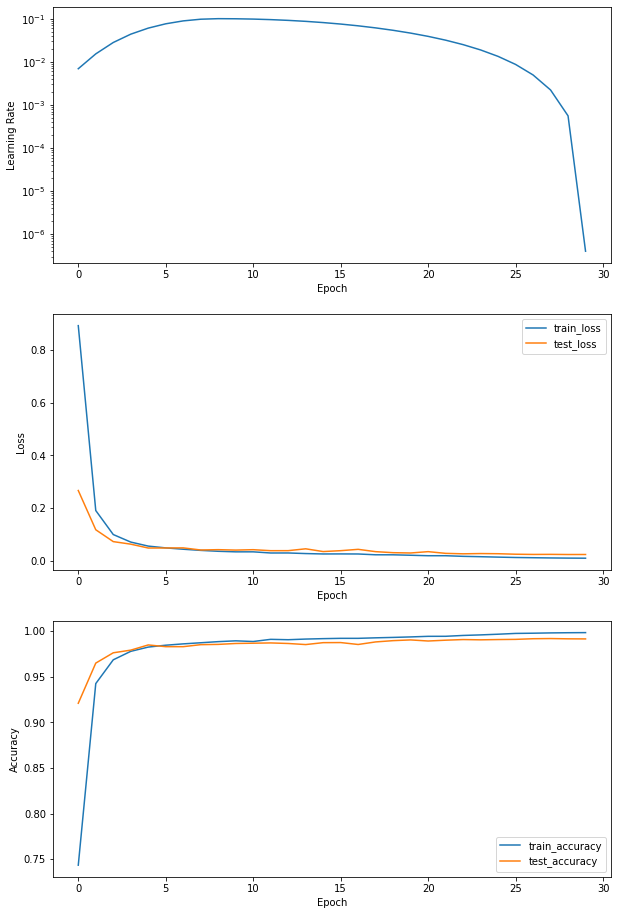

In [7]:
epochs = 30
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_dataloader), epochs=30)
history = train(train_dataloader, test_dataloader, optimizer, model, epochs=epochs, scheduler=scheduler)
evaluate(test_dataloader, model, nn.CrossEntropyLoss())
plot_history_data(history)